## Setup

In [1]:
import glob
import os
import re

from typing import Dict

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from procyon.data.data_utils import DATA_DIR

In [2]:
model_name = "ProCyon"

llama_name = "Llama3-8B-HG"
llama_it_name = "Llama3-8B-Instruct-HG"

mistral_name = "Mistral-large-HG"

gpt_aaseq_name = "GPT4-AA"
gpt_uniprot_name = "GPT4-UP"
gpt_hgnc_name = "GPT4-HG"

gpt_model_names =[
    gpt_aaseq_name,
    gpt_uniprot_name,
    gpt_hgnc_name
]

In [3]:
small_model = "Small (1X)"
med_model = "Medium (10X)"
frontier_model = "Frontier (>50X)"
model_classes = [
    small_model,
    med_model,
    frontier_model,
]

llm_models = [
    llama_name,
    llama_it_name,
    mistral_name,
] + gpt_model_names

llm_model_colors = {
    model: c for model, c in zip(llm_models, sns.color_palette("pastel"))
}
llm_model_colors[model_name] = "#9467BD"

# LLM as a judge

In [4]:
def parse_row(
    row: pd.Series,
) -> str:
    """Parse a single row of the judge response CSV."""
    found = re.findall("\[\[(\w)\]\]", row.response)
    if hasattr(row, "finish_reason") and row.finish_reason == "length":
        return "truncated"
    elif len(found) == 0:
        return "none"
    elif len(found) == 1:
        char = found[0]
        if char == "A":
            return row.prompt_a
        elif char == "B":
            return row.prompt_b
        elif char == "C":
            return "tie"
        else:
            print(f"bad char: {char}")
            return "none"
    else:
        print(f"bad output: {found}")
        return "none"


def check_file(
    df: pd.DataFrame,
    fname: str,
) -> pd.DataFrame:
    """Simple check for well-formed files (2 responses per protein.

    Note that this function was only added because some judge query runs
    had to be restarted part way through, resulting in some duplicate rows.
    """
    if len(df) % 2 != 0:
        df = df.drop_duplicates(["protein_id", "prompt_a", "prompt_b"])
        if len(df) % 2 != 0:
            raise ValueError(f"bad file: {fname}")
        else:
            print(f"duplicates in file: {fname}")
    return df

def parse_results_one(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Parse the results for a single judge response file."""
    res = []
    assert (df.protein_id.value_counts() == 2).all()

    # Parse dataframe by pairs of rows, corresponding to the two
    # possible permutations of the judged descriptions.
    for i in range(0, len(df), 2):
        selection_a = parse_row(df.iloc[i])
        selection_b = parse_row(df.iloc[i+1])
        # Response is valid only if both permutations output an actual decision,
        # rather than a truncation or no decision.
        is_valid =  selection_a in ["txplm", "llm", "tie"]  and selection_b in ["txplm", "llm", "tie"]
        res.append({
            "protein_id": df.protein_id.iloc[i],
            "selection_a": selection_a,
            "selection_b": selection_b,
            "valid": is_valid,
            "agree": is_valid and (selection_a == selection_b),
        })
    return (
        pd.DataFrame(res)
        .assign(
            result=lambda x: np.where(~x.valid,
                                     "invalid",
                                     np.where(~x.agree,
                                             "disagree",
                                             x.selection_a)),
            has_tie=lambda x: (x.selection_a == "tie") | (x.selection_b == "tie"),
            # In cases where one permutation results in a tie, and the other permutation
            # has a single winner, use the single winner as the "tiebreak".
            tiebreak_result=lambda x: np.where((x.result == "disagree") & x.has_tie,
                                                np.where(x.selection_a == "tie",
                                                         x.selection_b,
                                                         x.selection_a),
                                                x.result),
         )
        .drop(columns=["has_tie"])
    )

def parse_results_flat(
    files_dict: Dict,
) -> pd.DataFrame:
    """Parse a dict of many judge response files, organized by the compared model."""
    all_results = []
    for model_name, files in files_dict.items():
        for f in files:
            df = pd.read_csv(f).reset_index()
            df = check_file(df, f)
            res = parse_results_one(df)
            all_results.append(res.assign(versus=model_name))
    all_results = pd.concat(all_results)

    return all_results

In [5]:
judge_response_dir = os.path.join(
    DATA_DIR,
    "experimental_data",
    "llm_judge_eval",
    "judge_responses",
)

files = {
    gpt_aaseq_name: list(glob.glob(os.path.join(judge_response_dir, "gpt", "*aaseq*"))),
    gpt_uniprot_name: list(glob.glob(os.path.join(judge_response_dir, "gpt", "*uniprot*"))),
    gpt_hgnc_name: list(glob.glob(os.path.join(judge_response_dir, "gpt", "*gene_name*"))),
    mistral_name: list(glob.glob(os.path.join(judge_response_dir, "mistral", "*"))),
    llama_it_name: list(glob.glob(os.path.join(judge_response_dir, "llama3_it", "*"))),
}

In [6]:
flat_results = parse_results_flat(files)
flat_results.head()

duplicates in file: /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Instruct/experimental_data/llm_judge_eval/judge_responses/llama3_it/protein_uniprot_all.llm_judge_prompts.llama_instruct.gene_name.responses.csv
duplicates in file: /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Instruct/experimental_data/llm_judge_eval/judge_responses/llama3_it/protein_reactome_all.llm_judge_prompts.llama_instruct.gene_name.responses.csv


,protein_id,selection_a,selection_b,valid,agree,result,tiebreak_result,versus
0,A0A183,tie,none,False,False,invalid,invalid,GPT4-AA
1,A1IGU5,txplm,txplm,True,True,txplm,txplm,GPT4-AA
2,A5YM69,tie,none,False,False,invalid,invalid,GPT4-AA
3,A6NDH6,llm,txplm,True,False,disagree,disagree,GPT4-AA
4,A6NDL8,txplm,llm,True,False,disagree,disagree,GPT4-AA


In [7]:
models = [
    llama_it_name,
    mistral_name
] + gpt_model_names

plot_data = (
    flat_results
    .loc[lambda x: x.tiebreak_result.isin(["llm", "txplm"]) &  x.versus.isin(models)]
    .assign(
        model_class=lambda x: np.where(x.versus.str.contains("GPT4"),
                                       frontier_model,
                                       np.where(x.versus.str.contains("Mistral"),
                                                med_model,
                                                small_model)),
        result=lambda x: np.where(x.tiebreak_result == "llm", 1, 0),
    )
    [["result", "versus", "model_class"]]
)


Text(0.5, 1.0, 'model_class = Small (1X)')
Text(0.5, 1.0, 'model_class = Medium (10X)')
Text(0.5, 1.0, 'model_class = Frontier (>50X)')


<Figure size 1000x1000 with 0 Axes>

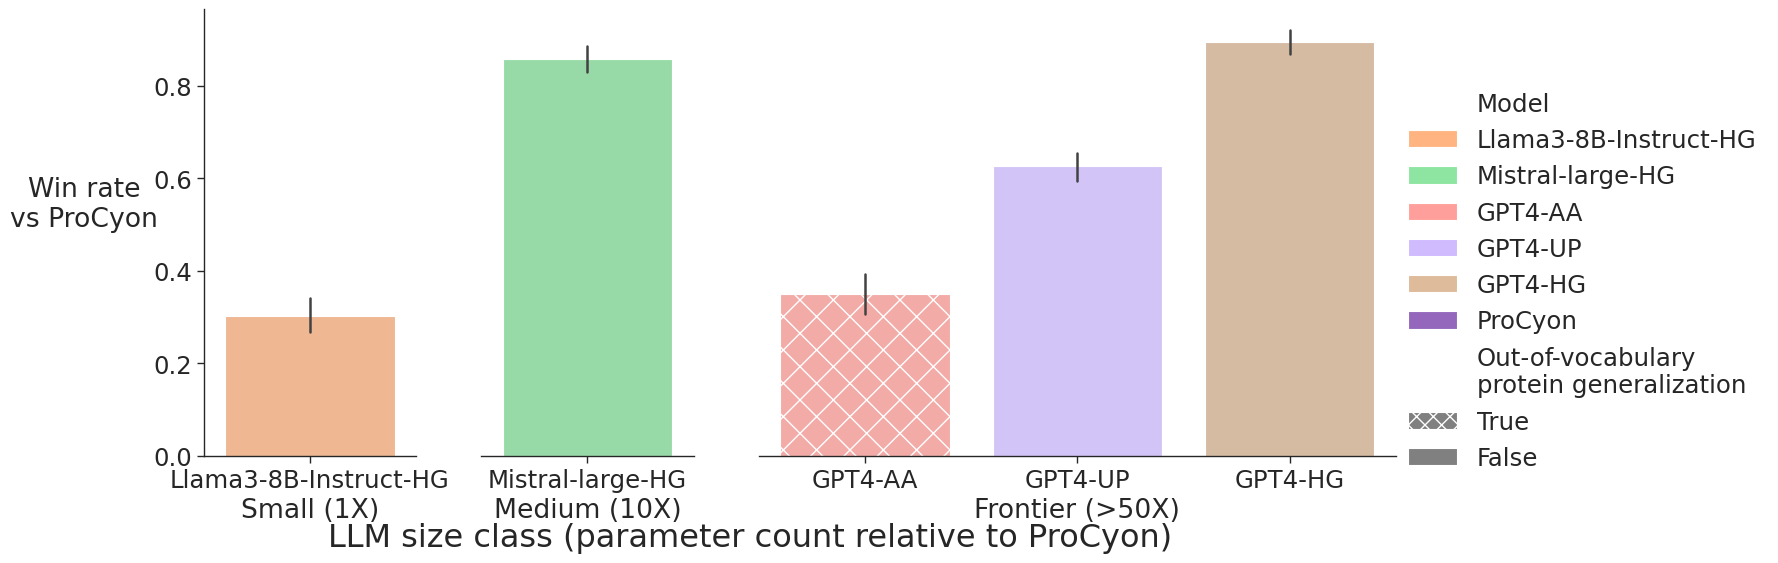

In [8]:
sns.set_theme(context="paper", style="ticks", font_scale=2)

plt.figure(figsize=(10, 10))

def estimate(vals):
    return (vals == 1).mean()

fg = sns.FacetGrid(
    col="model_class",
    col_order=model_classes,
    data=plot_data.loc[lambda x: x.versus.isin(models)],
    height=6,
    aspect=0.75,
    gridspec_kws={"width_ratios": [1/3, 1/3, 1]},
    sharex=False,
)

fg.map_dataframe(
    sns.barplot,
    x="versus",
    y="result",
    hue="versus",
    estimator=estimate,
    palette=llm_model_colors,
    data=plot_data,
)

sns.despine()
fg.set_xlabels("")
fg.set_ylabels(f"Win rate\nvs {model_name}", rotation="horizontal", ha="center", labelpad=50)
fg.despine()

for row in fg.axes:
    for i, ax in enumerate(row):
        print(ax.title)
        curr_title = ax.title.get_text()
        model_class = curr_title.replace("model_class = ", "")
        ax.set_title("")
        ax.set_xlabel(model_class)
        if i != 0:
            ax.yaxis.set_visible(False)
            ax.spines["left"].set_visible(False)
        if i == 2:
            want_rect = ax.patches[0]
            want_rect.set_hatch("x")

fg.figure.supxlabel(f"LLM size class (parameter count relative to {model_name})", y=0.05, va="top", x=0.4)

legend_data = [("Model",  mpatches.Patch(facecolor="gray", visible=False))]
want_models = [
    llama_it_name,
    mistral_name,
    gpt_aaseq_name,
    gpt_uniprot_name,
    gpt_hgnc_name,
    model_name,
]
legend_data += [(name, mpatches.Patch(facecolor=llm_model_colors[name])) for name in want_models]

true_patch = mpatches.Patch(facecolor="gray", label="True")
false_patch = mpatches.Patch(facecolor="gray", label="False")
true_patch.set_hatch("xx")
legend_data += [
    ("Out-of-vocabulary\nprotein generalization", mpatches.Patch(facecolor="gray", visible=False)),
    ("True", true_patch),
    ("False", false_patch),
]


fg._legend_data = {x:y for (x, y) in legend_data}

fg.add_legend()
plt.savefig("./llm_judge_win_rates_for_paper.svg")